In [1]:
import pandas as pd
import sys
import glob
import os
import re
import matplotlib.pyplot as plt
import seaborn as sns
sys.path.append("/home/bruce1996/data/Yi-Fung-Chuang/")

### Taxonomy profile pre-processing

In [ ]:
def merge_emu_output(path) :
    '''
    path : folder path of emu output
    sample format : sample + sample_barcode + .fastq
    emu output report format : sample name +'rel-abundance.tsv'
    '''
    #path = '/home/bruce1996/data/Yi-Fung-Chuang/within_individual/emu_output/'
    file_list = glob.glob(path +"*tsv")
    file_list.sort()
    for idx,file in enumerate(file_list) :
        _,filename = os.path.split(file)
        sample_name = filename.split('_')[1] + '_' + filename.split('_')[2]
        df = pd.read_csv(file,sep = '\t')
        #only extract abundance & species columns
        df = df.iloc[:,0:2]
        df.columns = [sample_name,'species']
        if idx == 0 :
            merge_df = df
        else :
            merge_df = pd.merge(merge_df,df,how = 'outer',on = 'species')
    merge_df = merge_df.fillna(0)
    idx = [1,0] + [x for x in range(2,merge_df.shape[1])]
    merge_df = merge_df.iloc[:,idx]
    merge_df.index = merge_df['species']

    return merge_df

In [47]:
probiotics = ["Bifidobacterium animalis","Bifidobacterium bifidum","Clostridium butyricum","Lactobacillus acidophilus",
               "Lactobacillus casei","Lactobacillus gasseri","Lactobacillus johnsonii","Lactobacillus paracasei",
               "Lactobacillus plantarum","Lactobacillus reuteri","Lactobacillus rhamnosus"]
genus = [x.split(' ')[0] for x in probiotics]
genus = list(set(genus))

In [14]:
garmark_pretest_path = '/home/bruce1996/data/Yi-Fung-Chuang/within_individual/probiotics_abundance_pretest.csv'
garmark_posttest_path = '/home/bruce1996/data/Yi-Fung-Chuang/within_individual/probiotics_abundance_posttest.csv'
garmark_pretest = pd.read_csv(garmark_pretest_path,index_col= 0)
garmark_posttest = pd.read_csv(garmark_posttest_path,index_col = 0)
garmark_pretest['species'] = garmark_pretest.index
garmark_posttest['species'] = garmark_posttest.index

In [16]:
garmark_pre_df = garmark_pretest.melt(id_vars='species')
garmark_pre_df.columns = ['Species','Sample','Relative_abundance']
garmark_pre_df['Class'] = ['Garmark_pretest'] * garmark_pre_df.shape[0]
garmark_post_df = garmark_posttest.melt(id_vars='species')
garmark_post_df.columns = ['Species','Sample','Relative_abundance']
garmark_post_df['Class'] = ['Garmark_posttest'] * garmark_post_df.shape[0]

In [19]:
#emu probiotics abundance
emu_output_path = '/home/bruce1996/data/Yi-Fung-Chuang/within_individual/emu_output/'
merge_df = merge_emu_output(emu_output_path)


In [52]:
idx = [bool(x in probiotics) for x in merge_df['species']]
probiotics_df = merge_df.loc[idx,:]
probiotics_df = probiotics_df.melt(id_vars='species')
probiotics_df.columns = ['Species','Sample','Relative_abundance']
sample = [x.split('_')[0] for x in probiotics_df['Sample']]
label = [x.split('_')[1] for x in probiotics_df['Sample']]
probiotics_df['Sample'] = sample
probiotics_df['Class'] = label
probiotics_df['Relative_abundance'] = probiotics_df['Relative_abundance'] * 100


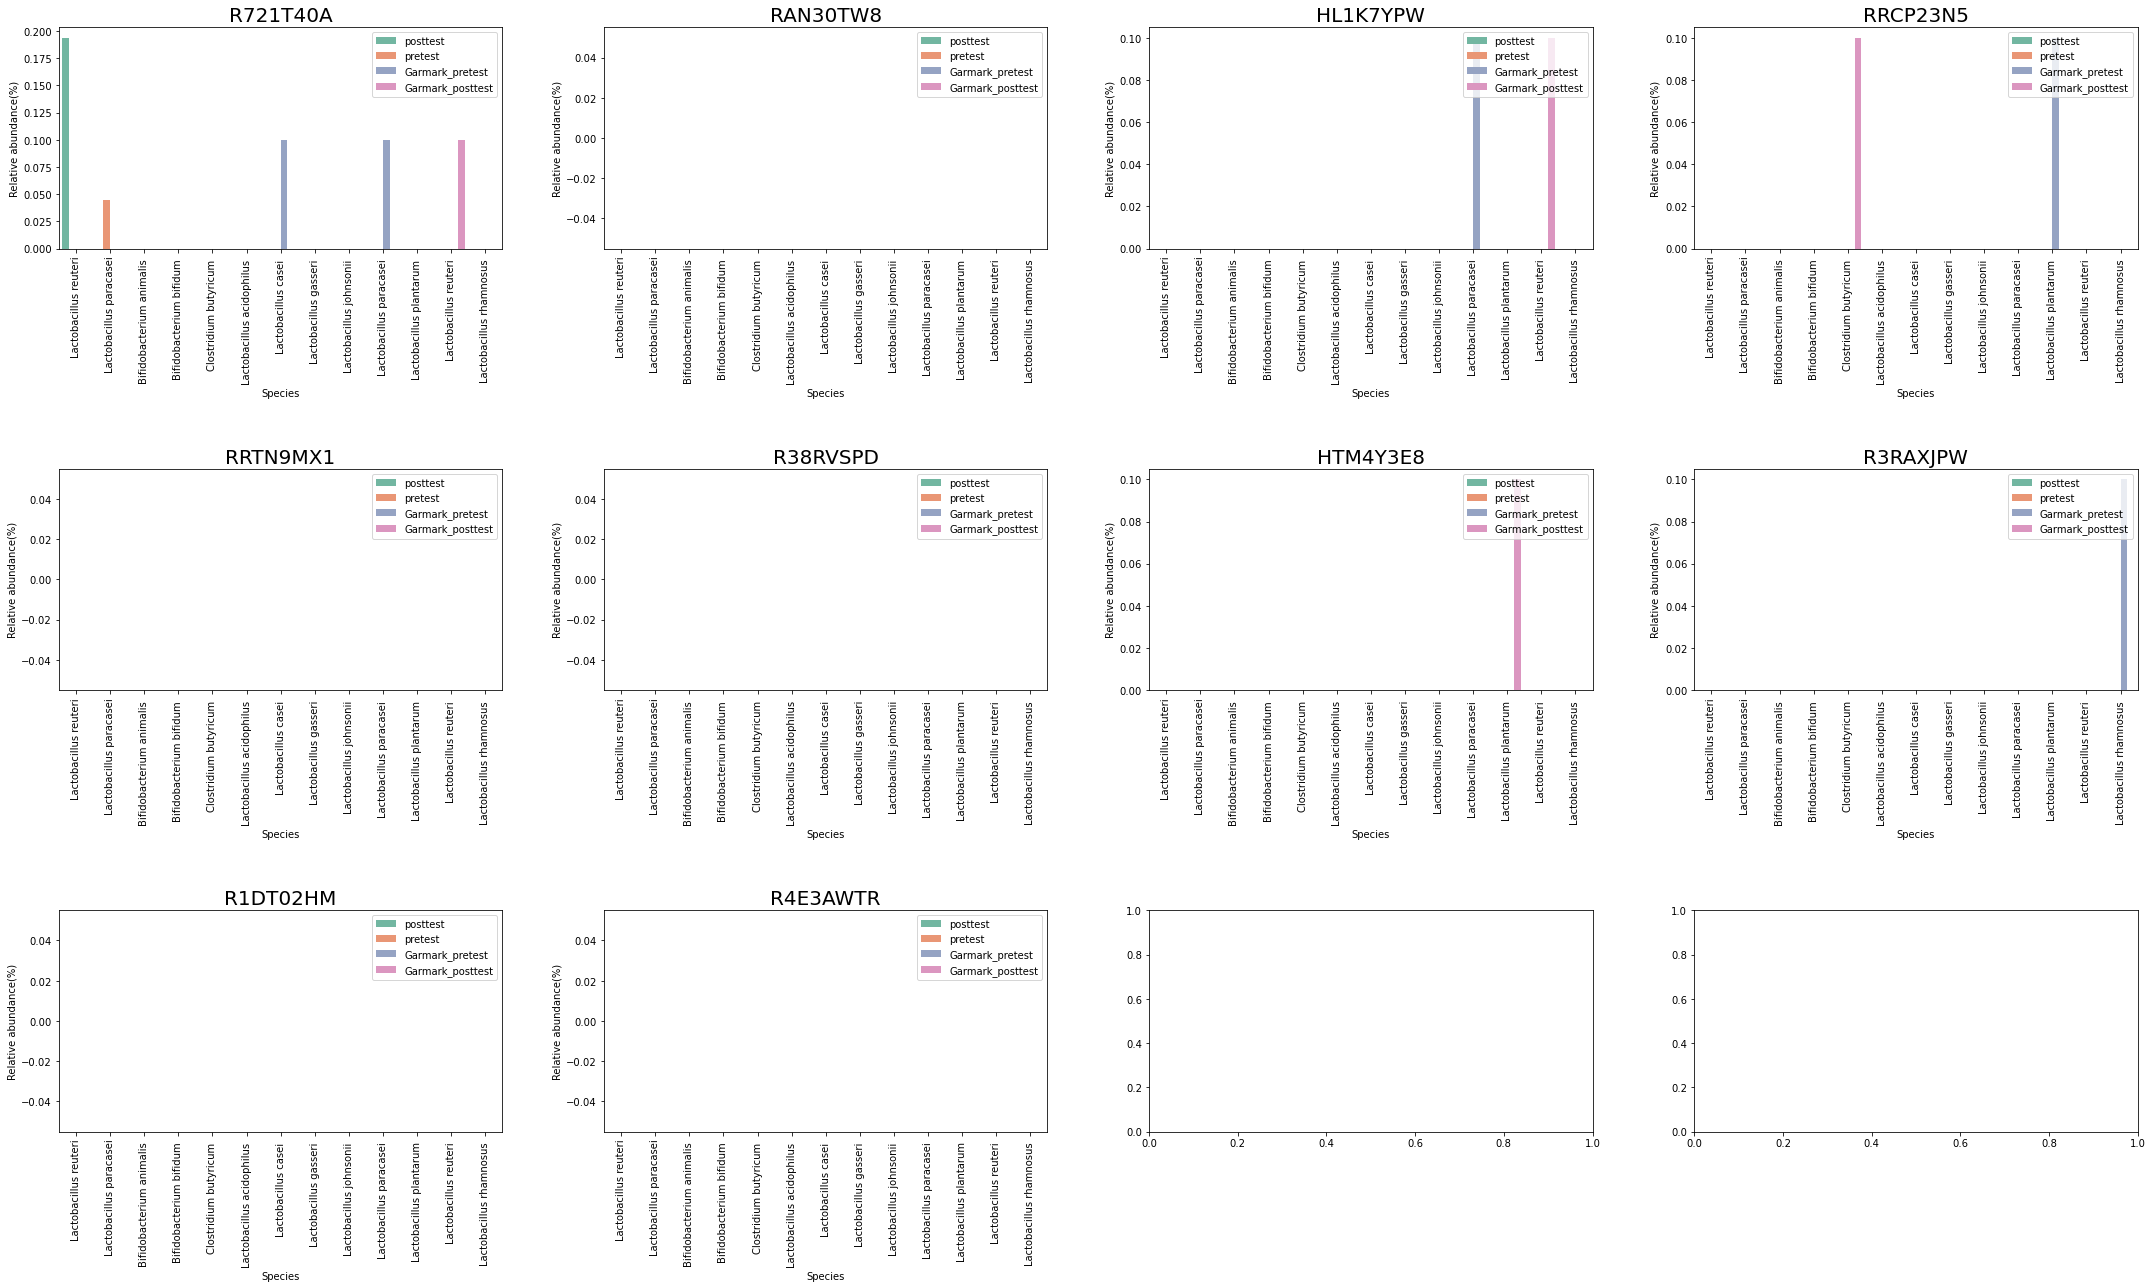

In [53]:
df = pd.concat([probiotics_df,garmark_pre_df,garmark_post_df],ignore_index=True)

sample = list(set(df['Sample']))
nrow = 3
ncol = 4
fig,axs = plt.subplots(nrow,ncol,figsize = (30,18),squeeze = False)
for r in range(nrow):
    for c in range(ncol):
        if r *ncol + c == 10 :
            break
        sample_idx = [ x == sample[r*ncol+c-1] for x in df['Sample']]
        df_subset = df.loc[sample_idx,:]
        sns.barplot(x='Species',y='Relative_abundance',hue='Class',data=df_subset,palette="Set2",ax = axs[r][c])
        axs[r][c].set_xticklabels(axs[r][c].get_xticklabels(),rotation = 90)
        axs[r][c].set_ylabel('Relative abundance(%)')
        axs[r][c].set_title(sample[r*ncol+c-1],fontsize = 20)
        axs[r][c].legend(loc="upper right")
plt.tight_layout(h_pad=5, w_pad=5)
#output fig
output_path = '/home/bruce1996/data/Yi-Fung-Chuang/within_individual/tmp/'
filename = 'Within_individual_test_of_between_emu_and_garmark.png'
plt.savefig(output_path + filename,dpi = 300,bbox_inches = "tight")



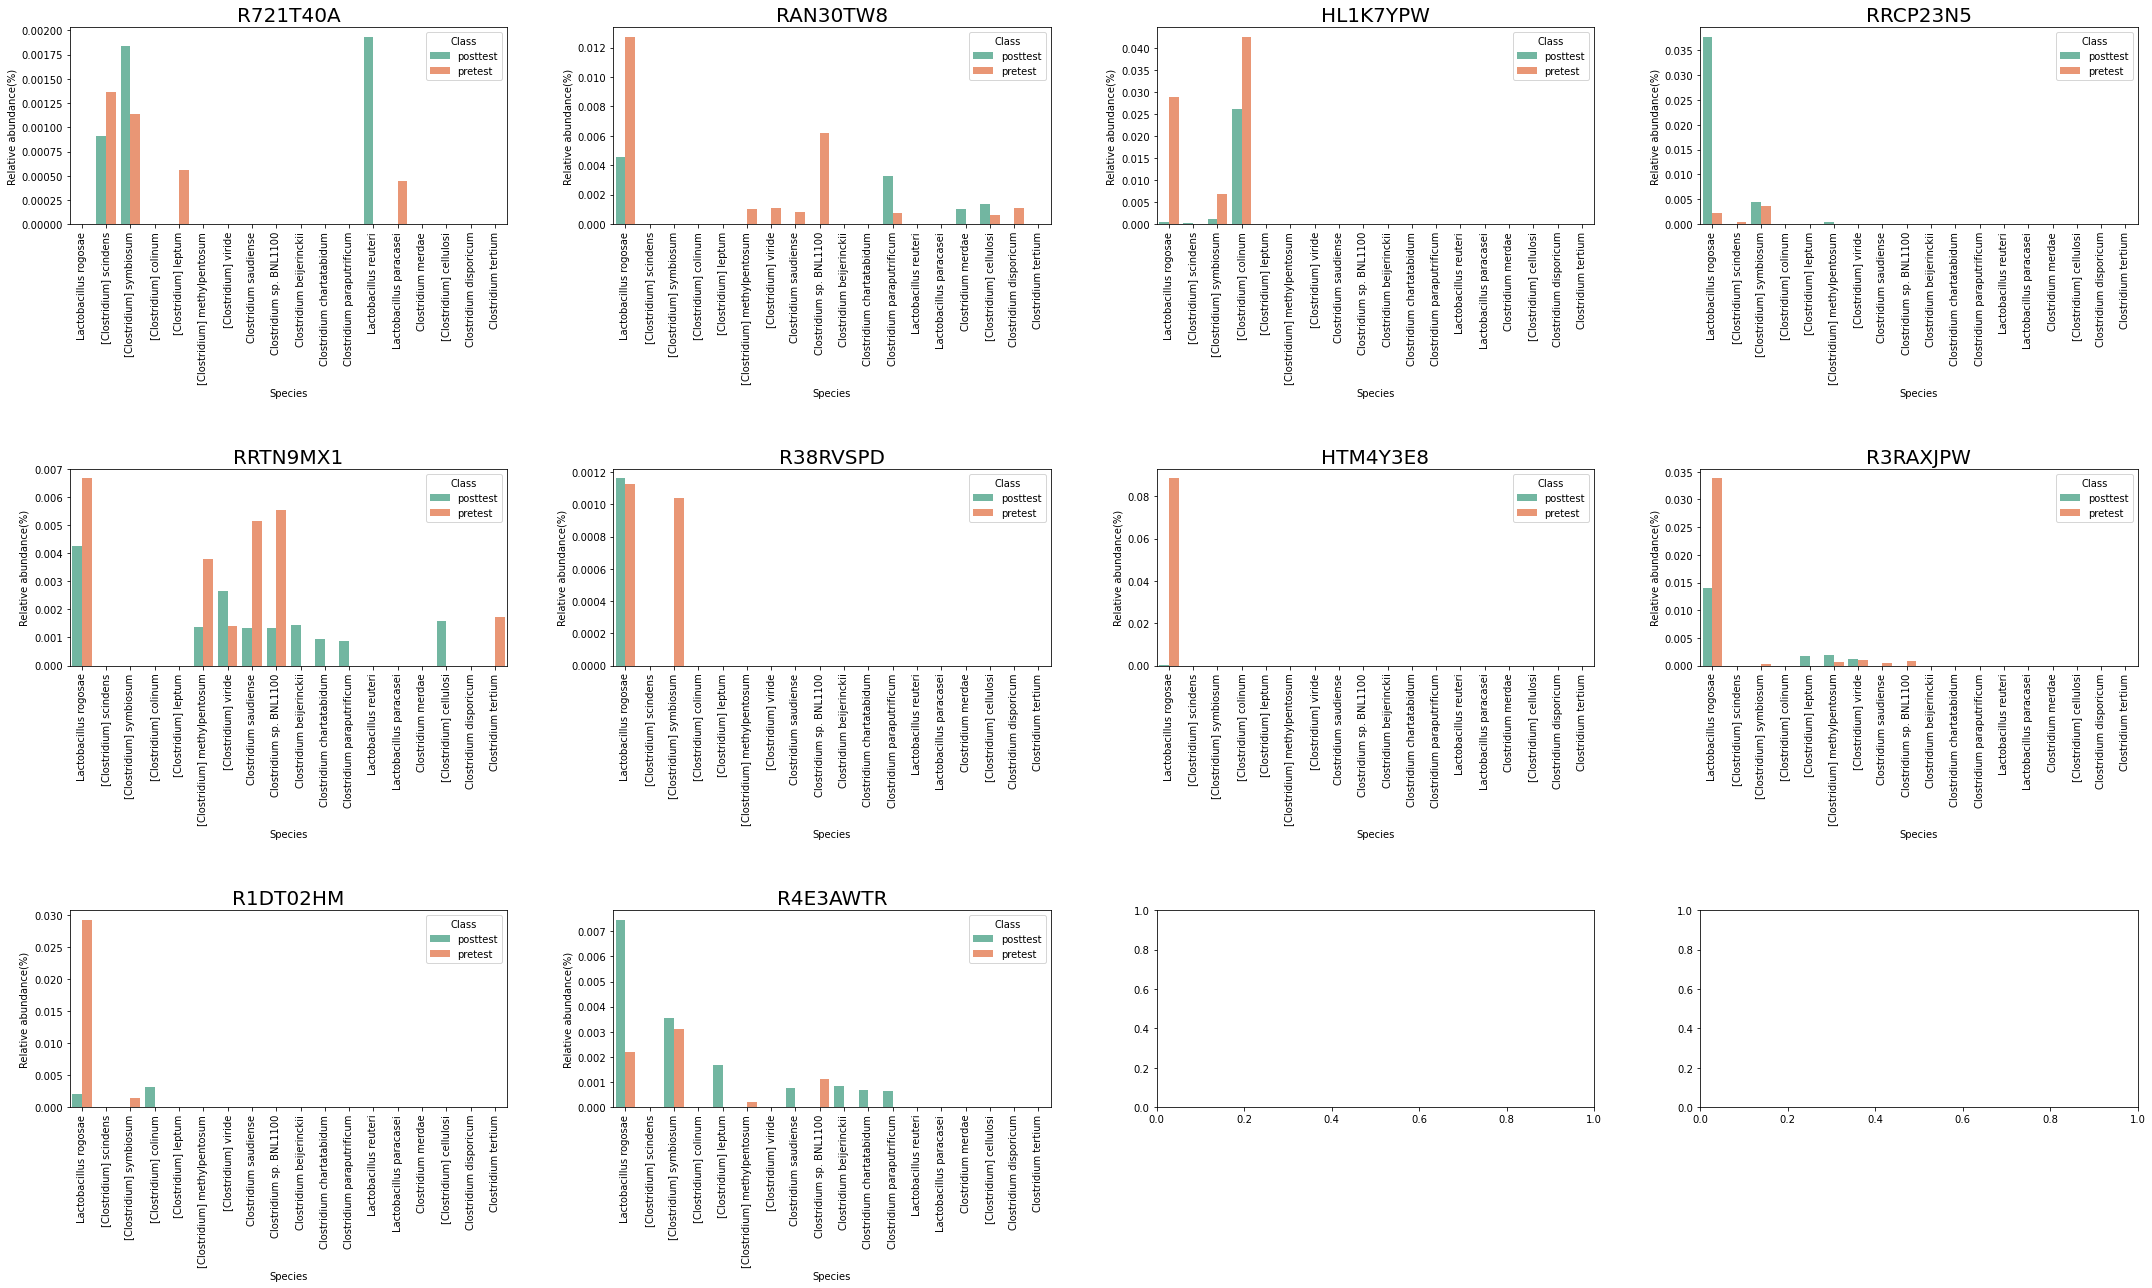

In [40]:
emu_output_path = '/home/bruce1996/data/Yi-Fung-Chuang/within_individual/emu_output/'
merge_df = merge_emu_output(emu_output_path)

a = [x for x in merge_df['species'] if bool(re.search(genus[0],x)) ] 
b = [x for x in merge_df['species'] if bool(re.search(genus[1],x)) ] 
c = [x for x in merge_df['species'] if bool(re.search(genus[2],x)) ] 
probiotics = a + b + c
probiotics_idx = [x in probiotics for x in merge_df['species']]
probiotics_df = merge_df.loc[probiotics_idx]
'''
probiotics_df = probiotics_df.melt(id_vars='species')
probiotics_df.columns = ['Species','Sample','Abundance']
sample = [x.split('_')[0] for x in probiotics_df['Sample']]
label = [x.split('_')[1] for x in probiotics_df['Sample']]
probiotics_df['Sample'] = sample
probiotics_df['Class'] = label
#convert to percentage
probiotics_df['Abundance'] = probiotics_df['Abundance'] * 100
'''
sample = list(set([x.split('_')[0] for x in probiotics_df.columns][1:]))
nrow = 3
ncol = 4
fig,axs = plt.subplots(nrow,ncol,figsize = (30,18),squeeze = False)
for r in range(nrow):
    for c in range(ncol):
        if r *ncol + c == 10 :
            break
        sample_idx = [bool(re.search(sample[r*ncol+c-1],x)) for x in list(probiotics_df.columns)]
        sample_idx[0] = True
        df = probiotics_df.loc[:,sample_idx]
        df = df.melt(id_vars='species')
        df.columns = ['Species','Sample','Abundance']
        samplename = [x.split('_')[0] for x in df['Sample']]
        label = [x.split('_')[1] for x in df['Sample']]
        df['Sample'] = samplename
        df['Class'] = label
        sns.barplot(x='Species',y='Abundance',hue='Class',data=df,palette="Set2",ax = axs[r][c])
        axs[r][c].set_xticklabels(axs[r][c].get_xticklabels(),rotation = 90)
        axs[r][c].set_ylabel('Relative abundance(%)')
        axs[r][c].set_title(sample[r*ncol+c-1],fontsize = 20)

output_path = '/home/bruce1996/data/Yi-Fung-Chuang/within_individual/tmp/'
dir_exist = os.path.exists(output_path)
if not dir_exist :
    os.makedirs(output_path)
filename = 'Within_individual_test_of_' + genus[1] + '.png'
plt.tight_layout(h_pad=5, w_pad=5)
plt.savefig(output_path + filename,dpi = 300,bbox_inches = "tight")